In [31]:
# IMPORT LIBRARIES
import itertools
import numpy as np
from pyentrp import entropy as ent
import matplotlib.pyplot as plt

In [32]:
# DEFINE FUNCTIONS
def mpe(mts, m, d):
    """
    This function computes the multivariate permutation entropy of a multivariate time series. 
    The algorithm follows the formulations of Morabito et al. (2012) and it is based for the most part on
    Nikolay Donets' pyEntropy code (2012).
        
    INPUTS are:
        - mts: multivariate time series of shape "N series x N samples"
        - m: order of possible permutation motifs
        - d: time-lag
        
    OUTPUTS are:
        - pe_channel: single series entropy
        - pe_cross: cross-series entropy
        
    References:
        - Morabito, F.C., Labate, D., La Foresta, F., Bramanti, A., Morabito, G. & Palamara, I. (2012). 
          Multivariate Multi-Scale Permutation Entropy for Complexity Analysis of Alzheimer’s Disease EEG.
          Entropy, 14, 1186-1202.
        - Donets, N. (2013). PyEntropy. Github repository, https://github.com/nikdon/pyEntropy
    """
    # initialize parameters
    n = len(mts[0])
    e = len(mts)
    permutations = np.array(list(itertools.permutations(range(m))))
    t = n - d * (m - 1)
    c = []
    p = []
    pe_channel = []
    
    for j in range(e):
        c.append([0] * len(permutations))
        
    # compute single series permutation entropy based on the multivariate distribution of motifs
    for f in range(e):
        for i in range(t):
            sorted_index_array = np.array(np.argsort(mts[f][i:i + d * m:d], kind='quicksort'))
            for j in range(len(permutations)):
                if abs(permutations[j] - sorted_index_array).any() == 0:
                    c[f][j] += 1
    
        p.append(np.divide(np.array(c[f]), float(t*e)))
        pe_channel.append(-np.nansum(p[f] * np.log2(p[f])))
    
    # compute the cross-series permutation entropy based on the multivariate distribution of motifs
    rp = []
    pe_cross = []
    for w in range(len(permutations)):
        rp.append(np.nansum(np.array(p)[:,w]))
    
    pe_cross = -np.nansum(rp * np.log2(rp))
        
    return pe_channel, pe_cross

def mmpe (mts, m, d, s):
    """
    This function computes the multivariate multiscale permutation entropy of a multivariate 
    time series. The algorithm follows the formulations of Morabito et al. (2012) and it is based for the 
    most part on Nikolay Donets' pyEntropy code (2012).
    
    INPUTS are:
        - mts: multivariate time series of shape "N series x N samples"
        - m: order of possible permutation motifs
        - d: time-lag
        - s: scale factor
        
    OUTPUTS are:
        - ms: list of differently scaled multivariate permutation entropies
        
    References:
        - Morabito, F.C., Labate, D., La Foresta, F., Bramanti, A., Morabito, G. & Palamara, I. (2012). 
          Multivariate Multi-Scale Permutation Entropy for Complexity Analysis of Alzheimer’s Disease EEG.
          Entropy, 14, 1186-1202.
        - Donets, N. (2013). PyEntropy. Github repository, https://github.com/nikdon/pyEntropy
    """
    
    # get coarsed series and compute the multivariate permutation entropy on each scale
    ms = []
    for a in range(s):
        coarse_time_series = []
        for f in range(len(mts)):
            coarse_time_series.append(ent.util_granulate_time_series(mts[f], a + 1))
        
        pe = mpe(coarse_time_series, m, d)
        ms.append(pe)

    return ms

In [33]:
# simulate lesser complex multivariate time series
mean1 = (1,2,3)
cov1 = [[0.1, 0.3, 0.2], 
        [0.3, 0.1, 0.3], 
        [0.2, 0.3, 0.1]]
mts1 = np.random.multivariate_normal(mean1, cov1, 50).T

# simulate more complex multivariate time series               
mean2 = (1,2,3)
cov2 = [[1.0, 0.3, 0.2], 
        [0.3, 1.0, 0.3], 
        [0.2, 0.3, 1.0]]
mts2 = np.random.multivariate_normal(mean2, cov2, 50).T

mts = [mts1, mts2]

/home/floriane/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.


In [34]:
m = 3 # motifs
d = 1 # delay
s = 3 # scale

# compute the multivariate multiscale permutation entropy
entropia = []
for i in range(len(mts)):
    entropia.append(mmpe(mts[i], m, d, s))

/home/floriane/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in log2
/home/floriane/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in multiply
/home/floriane/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in log2
/home/floriane/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in multiply


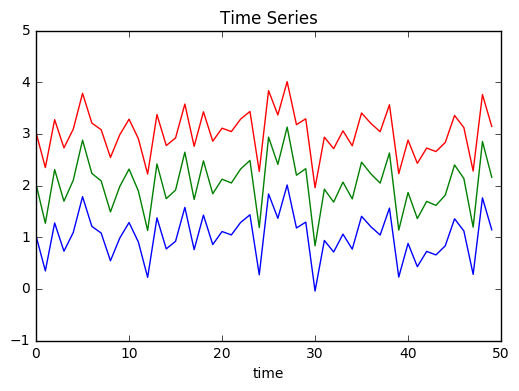

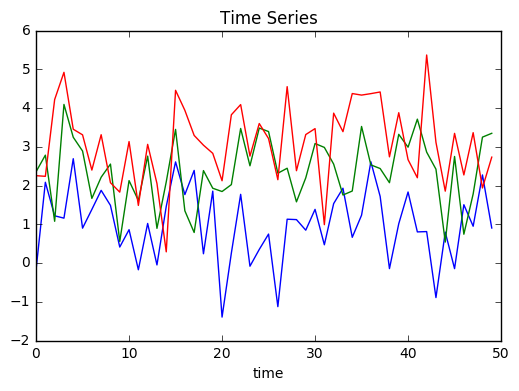

In [35]:
# plot the series
for j in range(len(mts)):
    plt.figure()
    plt.title('Time Series')
    plt.xlabel('time')
    for i in range(len(mts[j])):
        plt.plot(range(len(mts[j][i])), mts[j][i])
    plt.show()

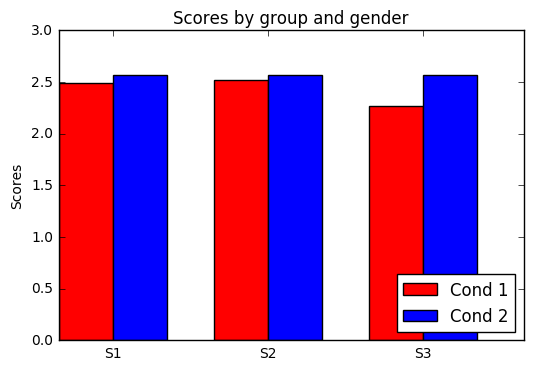

In [36]:
# plot the differences
N = 3
cond1_means = (entropia[0][0][1],entropia[0][1][1],entropia[0][2][1])
ind = np.arange(N)
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(ind, cond1_means, width, color='r')
cond2_means = (entropia[1][0][1],entropia[1][1][1],entropia[1][2][1])
rects2 = ax.bar(ind + width, cond2_means, width, color='b')
ax.set_ylabel('Scores')
ax.set_title('Entropy by series and condition')
ax.set_xticks(ind + width)
ax.set_xticklabels(('S1', 'S2', 'S3'))
ax.legend((rects1[0], rects2[0]), ('Cond 1', 'Cond 2'), loc=4)
plt.show()